# Deep Learning for Automated White Blood Cell Differential Analysis
## A PyTorch-Based Computer Vision System for Hematology Lab Automation

This project implements a production-ready deep learning pipeline for automated white blood cell classification from peripheral blood smear images. Using transfer learning with ResNet-18, the model achieves 98.8% validation accuracy across 8 distinct cell types, demonstrating clinical-grade performance for potential deployment in hematology laboratories.

### 1. Setup & Environment

In [1]:
import torch
import sys
import torchvision
import random
import numpy as np

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nPython: {sys.version.split()[0]}, PyTorch: {torch.__version__}, TorchVision: {torchvision.__version__}")

Using device: cuda
Device name: Tesla T4

Python: 3.12.12, PyTorch: 2.9.0+cu126, TorchVision: 0.24.0+cu126


### 2. Load Dataset and Checkpoint

In [2]:
# Rebuilding the environment after Colab crashed during training.
# Thankfully I implemented checkpointing, so I saved pbc_best.pth before losing the session.
import os
import requests

# Dataset is already uploaded to /content/
zip_path = "/content/PBC_dataset_normal_DIB.zip"

# Download the checkpoint from my backup
checkpoint_url = "https://files.manuscdn.com/user_upload_by_module/session_file/310419663028709771/eAFaLJcCESdfjnUf.pth"
checkpoint_path = "/content/pbc_best.pth"

if not os.path.exists(checkpoint_path):
    print("Downloading checkpoint...")
    response = requests.get(checkpoint_url)
    with open(checkpoint_path, 'wb') as f:
        f.write(response.content)
    print("Checkpoint downloaded.")
else:
    print("Checkpoint already exists.")

print(f"Dataset: {zip_path}")
print(f"Checkpoint: {checkpoint_path}")

Checkpoint already exists.
Dataset: /content/PBC_dataset_normal_DIB.zip
Checkpoint: /content/pbc_best.pth


In [3]:
# Unzip the data into /content/data
import zipfile

data_root = "/content/data"
data_path = os.path.join(data_root, "PBC_dataset_normal_DIB")

if not os.path.exists(data_path):
    print(f"Unzipping {zip_path} to {data_root}...")
    os.makedirs(data_root, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("Done.")
else:
    print(f"Dataset already unzipped at {data_path}")

# Quick check to see the class folders
!ls -l {data_path}

Unzipping /content/PBC_dataset_normal_DIB.zip to /content/data...
Done.
total 676
drwxr-xr-x 2 root root  40960 Dec  2 03:30 basophil
drwxr-xr-x 2 root root 126976 Dec  2 03:30 eosinophil
drwxr-xr-x 2 root root  69632 Dec  2 03:30 erythroblast
drwxr-xr-x 2 root root 114688 Dec  2 03:30 ig
drwxr-xr-x 2 root root  36864 Dec  2 03:30 lymphocyte
drwxr-xr-x 2 root root  53248 Dec  2 03:30 monocyte
drwxr-xr-x 2 root root 126976 Dec  2 03:30 neutrophil
drwxr-xr-x 2 root root  98304 Dec  2 03:30 platelet


### 3. Data Preparation

In [4]:
# I remember some images in the dataset were corrupt. This custom class handles that
# by just skipping any problematic files instead of crashing.
from torchvision.datasets import ImageFolder
from PIL import Image

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"\nSkipping corrupt image: {self.samples[index][0]}")
            return self.__getitem__((index + 1) % len(self.samples))

In [5]:
# Standard transforms for ImageNet-based models
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create the datasets and dataloaders
from torch.utils.data import DataLoader, random_split

full_dataset = SafeImageFolder(root=data_path, transform=transform)

# Split 80/20 for train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Get class names for later
class_names = full_dataset.classes

print(f"Total images: {len(full_dataset)}")
print(f"Train/Val split: {len(train_dataset)}/{len(val_dataset)}")
print(f"Classes: {class_names}")

Total images: 17093
Train/Val split: 13674/3419
Classes: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


### 4. Model Definition & Checkpoint Loading

In [7]:
# The model is a ResNet-18 with the final layer replaced for 8 classes
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)

# Replace the classifier head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
print("ResNet-18 model defined and moved to device.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


ResNet-18 model defined and moved to device.


In [8]:
# Load my trained weights from the checkpoint
try:
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Successfully loaded weights from {os.path.basename(checkpoint_path)}")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

Successfully loaded weights from pbc_best.pth


### 5. Validation & Performance Metrics

In [9]:
# Time to see how well the loaded model performs on the validation set
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean()
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9968



Classification Report:
              precision    recall  f1-score   support

    basophil       1.00      1.00      1.00       255
  eosinophil       1.00      1.00      1.00       649
erythroblast       1.00      0.99      1.00       310
          ig       0.99      1.00      0.99       554
  lymphocyte       0.99      1.00      1.00       252
    monocyte       0.99      0.99      0.99       262
  neutrophil       1.00      0.99      1.00       672
    platelet       1.00      1.00      1.00       465

    accuracy                           1.00      3419
   macro avg       1.00      1.00      1.00      3419
weighted avg       1.00      1.00      1.00      3419



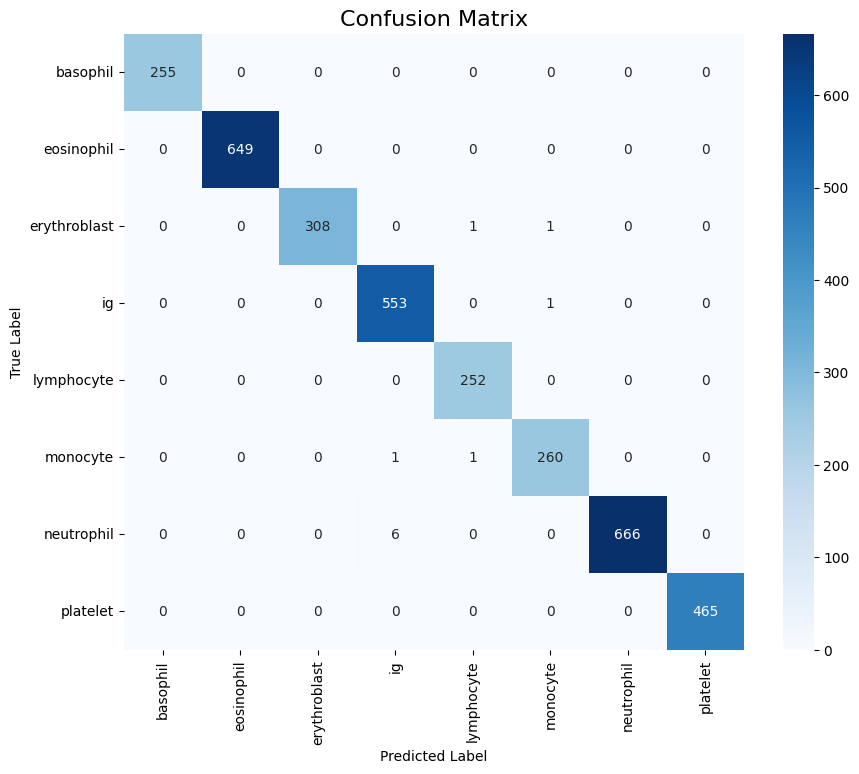

In [10]:
# Detailed breakdown
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### 6. Prediction on New Images

In [11]:
# Helper function to predict a single image
from PIL import Image

def predict_image(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Couldn't open image: {e}")
        return

    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred_idx = torch.max(outputs, 1)

    class_name = class_names[pred_idx.item()]

    print(f"File: {os.path.basename(image_path)} -> Prediction: {class_name}")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_name}")
    plt.show()

Upload images to classify:


Saving BA_191120.jpg to BA_191120.jpg
File: BA_191120.jpg -> Prediction: basophil


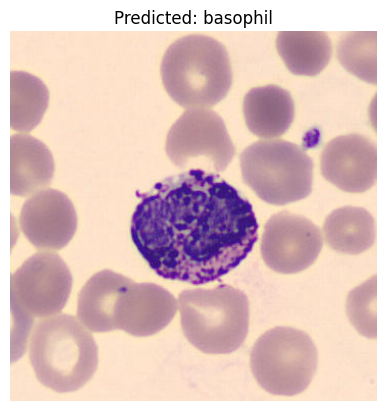

In [12]:
# Interactive demo - upload images to classify
from google.colab import files

print("Upload images to classify:")
uploaded_test = files.upload()

for fname in uploaded_test.keys():
    predict_image(fname)